In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt



In [2]:
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TEST.ts")





In [42]:
def read_ieeeppg_ts(path, num_dims=5):
    X_list = []
    y_list = []
    in_data = False
    print("here")
    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if line.lower() == "@data":
                in_data = True
                continue
            if not in_data or not line:
                continue
            #input('a')
            #print("here2")
            parts = line.split(":")
            print(parts[5], len(parts))
            #input('a')
            if len(parts) != 2:
                continue
            #breakpoint()
            print(line)
            kekkonen=1
            feature_str, target_str = parts
            feature_values = [float(x) for x in feature_str.strip().split(",")]
            target_values = [float(x) for x in target_str.strip().split(",")]

            # Reshape feature values to (num_dims, series_len)
            series_len = len(feature_values) // num_dims
            feature_array = np.array(feature_values).reshape(num_dims, series_len)

            X_list.append(feature_array)
            y_list.append(np.array(target_values))

    X = np.stack(X_list)  # Shape: (samples, dims, series_len)
    y = np.stack(y_list)  # Shape: (samples, series_len)
    return X, y

In [42]:
X, y = read_ieeeppg_ts("/Users/kpalomak/data/IEEEPPG_TRAIN.ts", num_dims=5)
print(X.shape)  # -> (n_samples, 5, 1000)
print(y.shape)  # -> (n_samples, 1000)

here


KeyboardInterrupt: 

KeyboardInterrupt: 

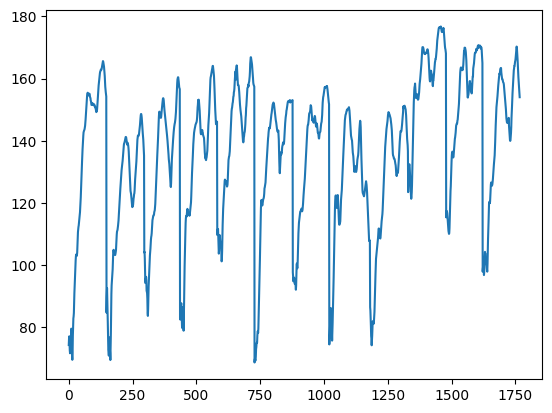

In [6]:
plt.plot(np.array(y_train,'float'))

In [215]:
def df_to_np(X):
    return np.stack([
        np.stack(row.values)  # stack channels
        for _, row in X.iterrows()  # iterate over samples
    ])


In [163]:
X_train_np=df_to_np(X_train)
y_train_np=df_to_np(y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'

In [158]:
print(X_np.shape)
print("X np start", X_np[0,0,:5])
def make_batches(X_np)
    shape=X_np.shape
    nu_time_steps=shape[2]
    nu_features=shape[1]
    nu_samples=shape[0]
    batch_size=100
    assert np.mod(nu_time_steps*nu_samples,batch_size)==0
    nu_batches=int(nu_time_steps*nu_samples/batch_size)
    X_np_new=X_np.reshape(nu_batches,nu_features,batch_size)

print(X_np_new.shape)
print("X np new start", X_np_new[0,0,:5])
print(X_np[1,0,:10])
print(X_np_new[10,0,:5])


(1768, 5, 1000)
X np start [-23.  -24.  -26.5 -27.  -30. ]


AssertionError: 

In [126]:
X_train.head()

,dim_0,dim_1,dim_2,dim_3,dim_4
0,0 -23.0 1 -24.0 2 -26.5 3 -27....,0 4.0 1 6.0 2 3.0 3 3....,0 -0.0702 1 -0.0702 2 -0.0546 3 ...,0 0.3432 1 0.3588 2 0.3666 3 ...,0 0.9594 1 0.9438 2 0.9360 3 ...
1,0 -20.5 1 -19.0 2 -20.0 3 -19....,0 -37.0 1 -38.5 2 -40.5 3 -41....,0 0.4056 1 0.4212 2 0.4368 3 ...,0 0.6084 1 0.6162 2 0.6084 3 ...,0 0.5148 1 0.4992 2 0.4758 3 ...
2,0 22.0 1 23.5 2 22.5 3 23....,0 12.5 1 13.5 2 11.5 3 13....,0 0.4758 1 0.4758 2 0.4758 3 ...,0 0.6864 1 0.6864 2 0.6864 3 ...,0 0.3900 1 0.3900 2 0.3978 3 ...
3,0 -5.5 1 -5.5 2 -6.5 3 -6....,0 -1.0 1 -0.5 2 -1.5 3 -1....,0 0.4602 1 0.4602 2 0.4602 3 ...,0 0.6708 1 0.6786 2 0.6708 3 ...,0 0.3978 1 0.4134 2 0.4056 3 ...
4,0 30.5 1 27.0 2 26.0 3 24....,0 74.5 1 70.0 2 67.0 3 62....,0 0.6162 1 0.6162 2 0.6240 3 ...,0 0.7098 1 0.6942 2 0.6786 3 ...,0 0.3978 1 0.3900 2 0.3744 3 ...


In [114]:
3096*5

15480

In [101]:

def make_batches_old(X, batch_size):
    nu_samples=X.shape[0]
    remainder=np.mod(nu_samples,batch_size)
    end=nu_samples-remainder
    nu_batches=int(end/batch_size)
    if len(X.shape)>1:
        nu_features=X.shape[1]
        return X[:end,:].reshape(nu_batches,batch_size,nu_features)  
    else:
        return X[:end].reshape(nu_batches,batch_size)  


    

In [102]:
batch_size=100
X_train=make_batches(X_train, batch_size)
X_test=make_batches(X_test, batch_size)


In [103]:
y_train=make_batches(y_train, batch_size)
y_test=make_batches(y_test, batch_size)


In [104]:
print(y_train.shape,
y_test.shape,
X_train.shape,
X_test.shape)

(17, 100) (13, 100) (17, 100, 5) (13, 100, 5)


In [85]:
from scipy.signal import find_peaks

def compute_hr_from_ecg(ecg_window, fs=125):
    peaks, _ = find_peaks(ecg_window, distance=fs*0.4)  # 0.4 sec = 150 bpm
    if len(peaks) < 2:
        return np.nan  # not enough data
    rr_intervals = np.diff(peaks)  # in samples
    mean_rr = np.mean(rr_intervals)
    hr = 60 * fs / mean_rr
    return hr

In [105]:
hr=[]
for ecg_window in y_train:
    hr.append(compute_hr_from_ecg(ecg_window))

In [107]:
print(len(hr))

17


In [84]:
# 1. Generate synthetic multi-wavelength time series data
n_samples = 1000
seq_len = 100  # length of each time series
channels = 3   # green, red, IR

# Simulate signals with sine waves and noise
def simulate_ppg_waveform(freq, noise=0.05):
    t = np.linspace(0, 1, seq_len)
    return np.sin(2 * np.pi * freq * t) + noise * np.random.randn(seq_len)

X = np.zeros((n_samples, channels, seq_len))
y = np.zeros(n_samples)

np.random.seed(42)
for i in range(n_samples):
    mean_hr = 75  # mean resting HR in bpm
    std_dev_hr = 10  # standard deviation in bpm
    hr = np.random.normal(mean_hr, std_dev_hr)  # generate HR with normal distribution
    freq = hr / 60  # convert to Hz
    X[i, 0, :] = simulate_ppg_waveform(freq, noise=0.1)  # green
    X[i, 1, :] = simulate_ppg_waveform(freq, noise=0.12)  # red
    X[i, 2, :] = simulate_ppg_waveform(freq, noise=0.15)  # IR
    y[i] = hr

X.shape

(1000, 3, 100)

In [10]:
# Train/test split
#n_samples = 1000

#split = int(0.8 * n_samples)
#X_train, X_test = X[:split], X[split:n_samples]
#y_train, y_test = y[:split], y[split:n_samples]
# Convert X_train DataFrame to a NumPy array
X_train_np = np.array([row.values for _, row in X_train.iterrows()])
y_train_np = np.array(y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [11]:
print(X_train.dtypes)

dim_0    object
dim_1    object
dim_2    object
dim_3    object
dim_4    object
dtype: object


In [9]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [10]:
# 3. Train the model
model = PPGCNN()
#model = PPGTransformer()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")

# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()
    targets = y_test_tensor.squeeze().numpy()
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")



AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

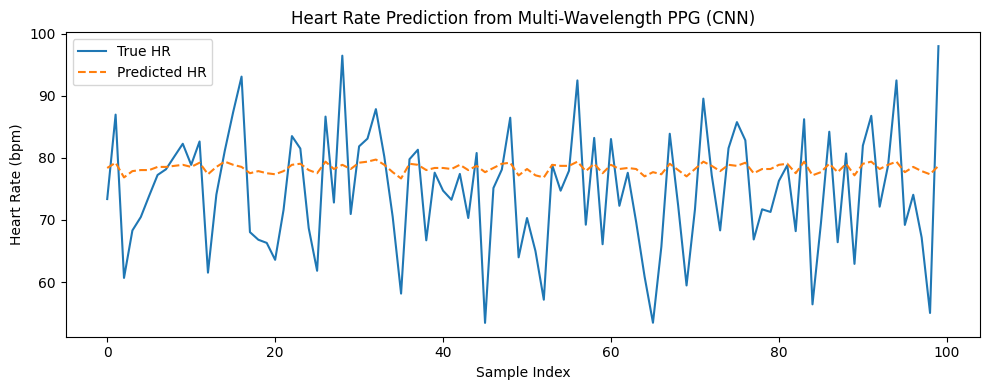

<Figure size 640x480 with 0 Axes>

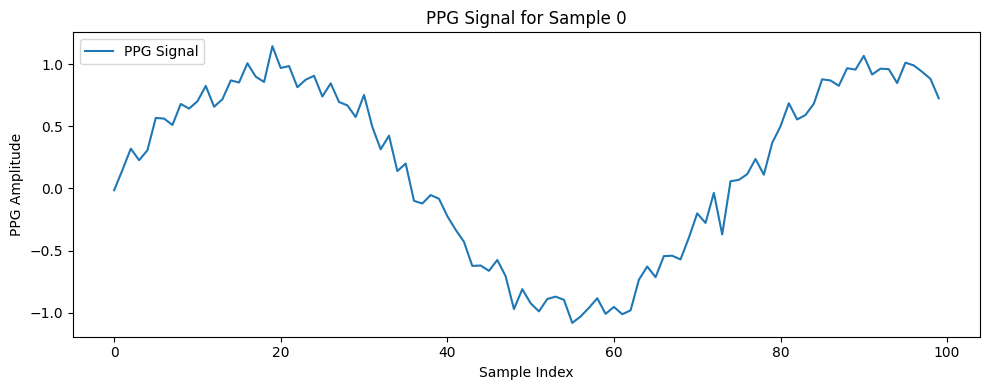

In [10]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets[:100], label="True HR")
plt.plot(preds[:100], label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot

# 6. Plot PPG data
plt.figure(figsize=(10, 4))
plt.plot(X[0,0,:], label="PPG Signal")  # Assuming X is your input PPG data
plt.title("PPG Signal for Sample 0")
plt.xlabel("Sample Index")
plt.ylabel("PPG Amplitude")
plt.legend()
plt.tight_layout()
plt.show()  # Display the second plot